# MVC project: Get the Data
- [GitHub](https://github.com/romainmartinez/mvc)

## 0. Setup

In [1]:
# Common imports
import pandas as pd
import numpy as np
import os

# the 'mvc' directory contains functions used but not necessary to understand the story
import mvc

# Figures
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sns.set_context("paper")

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 1. Get the Data

In [2]:
DATA_PATH = '/home/romain/Downloads/mvc'
DATA_FORMAT = 'only_max'  # could be either 'only_max', '3000_points' or '100_points'

In [3]:
mat = mvc.fileio.ImportMat(DATA_PATH, DATA_FORMAT, export='dict', normalize=False)

data format: only_max
project 'Sylvain_2015_only_max' loaded (10 participants)
project 'Landry2016_only_max' loaded (15 participants)
project 'Landry2012_only_max' loaded (18 participants)
project 'Tennis_only_max' loaded (16 participants)
project 'Violon_only_max' loaded (10 participants)
project 'Patrick_2013_only_max' loaded (16 participants)
project 'Yoann_2015_only_max' loaded (22 participants)
project 'Landry2013_only_max' loaded (21 participants)
project 'Landry2015_1_only_max' loaded (14 participants)
project 'Landry2015_2_only_max' loaded (11 participants)
	sample shape: (10, 12, 16)
	total participants: 152


/home/romain/Documents/codes/mvc/mvc/fileio.py:53: RuntimeWarning: All-NaN slice encountered
  max_mvc = np.nanmax(mat[dataset_name][iparticipant, imuscle, :])


In [4]:
# Variables names
DATASETS_NAMES = mat.datasets
MUSCLES_NAMES = ['upper trapezius', 'middle trapezius', 'lower trapezius', # 0, 1, 2
           'anterior deltoid', 'middle deltoid', 'posterior deltoid',      # 3, 4, 5
           'pectoralis major', 'serratus anterior', 'latissimus dorsi',    # 6, 7, 8
           'supraspinatus', 'infraspinatus', 'subscapularis']              # 9, 10, 11
COLUMNS_NAMES = ['datasets', 'participants', 'muscles', 'tests', 'mvc']
N_TEST = 16

In [5]:
# dict to single dataframe
df_tidy = pd.DataFrame({
    'participant': mat.data['participants'],
    'dataset': mat.data['datasets'],
    'muscle': mat.data['muscles'],
    'test': mat.data['tests'],
    'mvc': mat.data['mvc'],
}).dropna()

df_tidy.head()

,dataset,muscle,mvc,participant,test
0,0,0,0.131901,0,0
1,0,0,0.091436,0,1
2,0,0,0.112007,0,2
3,0,0,0.106817,0,3
4,0,0,0.085951,0,4


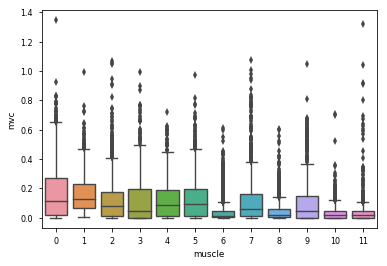

In [6]:
sns.boxplot(x='muscle', y='mvc', data=df_tidy)
plt.show()

## 2. Prepare the Data for Machine Learning

In [7]:
# convert from tidy to wide dataframe
df_wide = df_tidy.pivot_table(index=['dataset', 'participant', 'muscle'], columns='test', values='mvc',
                              fill_value=np.nan).reset_index()

In [8]:
# drop useless features
df_wide = df_wide.drop(['dataset', 'participant'], axis=1)

In [9]:
# get new features
temp = df_wide.copy().drop('muscle', axis=1)
df_wide['max'] = temp[temp.columns[1:]].max(axis=1)   # row max value

In [10]:
print(f'DataFrame shape: {df_wide.shape}')
df_wide.head()

DataFrame shape: (1468, 18)


test,muscle,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,max
0,0,0.131901,0.091436,0.112007,0.106817,0.085951,0.040268,0.033935,0.059248,0.105998,0.087777,0.028700,0.102914,0.012532,0.029702,0.077770,NaN,0.112007
1,1,0.209955,0.357945,0.339552,0.184616,0.249566,0.233603,0.114915,0.047925,0.265440,0.266440,0.133096,0.264917,0.041322,0.022607,0.341100,NaN,0.357945
2,2,0.162873,0.093305,0.409138,0.279272,0.196073,0.098213,0.156744,0.042138,0.146441,0.251222,0.043447,0.179067,0.024739,0.087391,0.240742,NaN,0.409138
3,4,0.087598,0.086329,0.102634,0.085689,0.083726,0.051671,0.011998,0.023230,0.079060,0.069491,0.079671,0.075335,0.012705,0.017431,0.087955,NaN,0.102634
4,5,0.170896,0.391435,0.328289,0.210572,0.169269,0.291393,0.062967,0.012713,0.212864,0.251469,0.269839,0.221003,0.025882,0.011095,0.312398,NaN,0.391435


In [11]:
# one-hot encoding 'muscle' feature
encoder = mvc.util.CategoricalEncoder(encoding="onehot-dense")
muscles_1hot = encoder.fit_transform(df_wide['muscle'].values.reshape(-1,1))
muscles = pd.DataFrame(muscles_1hot.astype(int)).add_prefix('muscle_')
muscles.columns = MUSCLES_NAMES

In [12]:
df = muscles.join(df_wide)

In [13]:
print(f'dataframe shape: {df.shape}')
print(f'columns names:\n {list(df.columns)}')
df.head()

dataframe shape: (1468, 30)
columns names:
 ['upper trapezius', 'middle trapezius', 'lower trapezius', 'anterior deltoid', 'middle deltoid', 'posterior deltoid', 'pectoralis major', 'serratus anterior', 'latissimus dorsi', 'supraspinatus', 'infraspinatus', 'subscapularis', 'muscle', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 'max']


,upper trapezius,middle trapezius,lower trapezius,anterior deltoid,middle deltoid,posterior deltoid,pectoralis major,serratus anterior,latissimus dorsi,supraspinatus,...,7,8,9,10,11,12,13,14,15,max
0,1,0,0,0,0,0,0,0,0,0,...,0.059248,0.105998,0.087777,0.028700,0.102914,0.012532,0.029702,0.077770,NaN,0.112007
1,0,1,0,0,0,0,0,0,0,0,...,0.047925,0.265440,0.266440,0.133096,0.264917,0.041322,0.022607,0.341100,NaN,0.357945
2,0,0,1,0,0,0,0,0,0,0,...,0.042138,0.146441,0.251222,0.043447,0.179067,0.024739,0.087391,0.240742,NaN,0.409138
3,0,0,0,0,1,0,0,0,0,0,...,0.023230,0.079060,0.069491,0.079671,0.075335,0.012705,0.017431,0.087955,NaN,0.102634
4,0,0,0,0,0,1,0,0,0,0,...,0.012713,0.212864,0.251469,0.269839,0.221003,0.025882,0.011095,0.312398,NaN,0.391435


## 3. Save Data

In [14]:
df.to_hdf('mvc.h5', 'MVC', format='table')